Analysis of the number of activated cells over time

In [302]:
import pandas as pd
import scipy.optimize as opt
import scipy.spatial as spat
import scipy.signal as sig
import scipy.interpolate as interp
from math import ceil, floor
import numba

In [216]:
@numba.njit
def get_rms(y):
    return np.sqrt(np.mean(y**2))


@numba.njit
def logistic(x, a, b, N):
    return N/(1 + a * np.exp(-b * x))


@numba.njit
def logistic_norm(x, a, b):
    return 1/(1 + a * np.exp(-b * x))

In [11]:
@numba.njit
def rms_mask(m, loc, ip):
    """
    Returns RMS distance of pixels in a mask to location loc, 
    in units of interpixel distance ip.
    
    m  : mask, as a Numpy array of indices of shape (ndim, npix)
    """
    
    ndim, npix = m.shape
    
    # Catch empty masks
    if npix==0:
        return 0
    
    # calculate squared distance
    sqd = np.zeros(npix)
    for i in range(ndim):
        sqd += (m[i] - loc[i])**2
    
    # Root-mean of squared distance (RMSD) in units of distance
    return np.sqrt(np.mean(sqd)) * ip

In [12]:
def chull_mask(m, ip):
    """
    Returns area of the convex hull of pixels in a mask, in units
    of squared distance
    
    m  : mask as a 2D Numpy array of shape (ndim, npix)
    ip : inter-pixel distance
    """
    
    # If not enough points, return 0
    ndim, npix = m.shape
    if npix < 3:
        return 0
    
    return spat.ConvexHull(ip * m.T).volume

<hr>

- Unstage the data commits, put data in an ignored data folder
- Identify some examples, put them in a shared folder, push
- Run DDE sims on them (check for accuracy and speed)
- Calculate growth metrics and validate
- Generate a very rough figure using these examples
- Write workflow from data file to metrics based on params, port to script
- Test out script on subset of data files, push, generate the same rough figure
- Run the full script, push, generate a denser figure

In [132]:
def tc_rhs(E, E_past, A_past, args):

    alpha, k, p, delta, lambda_ = args

    E_bar = A_past @ E_past
    dE_dt = lambda_ + alpha * (E_bar**p) / (k**p + (delta * E_past)**p + E_bar**p) - E

    return dE_dt

E0 = 0

alpha = 3
k = 0.01
p = 2
delta = 3
lambda_ = 1e-5

dde_args = alpha, k, p, delta, lambda_

delay = 0.4

In [133]:
import os
os.getcwd()

'C:\\Users\\Pranav\\git\\evomorph\\sandbox'

In [26]:
dir_name = f"../2020-08-10_active_vor_lattice_test"

In [27]:
from glob import glob
files = glob(dir_name + "/*")
files = [f for f in files if "tf50" in f]

In [28]:
prefixes = ["_".join(f.split("_")[:-3]).split("\\")[-1] for f in files if f.endswith(".npy")]
prefixes = [f for f in prefixes if f.startswith("per3.80")]

In [29]:
prefixes

['per3.80_vel1.00e+00_tf50',
 'per3.80_vel1.00e-01_tf50',
 'per3.80_vel1.00e-02_tf50',
 'per3.80_vel1.58e-01_tf50',
 'per3.80_vel1.58e-02_tf50',
 'per3.80_vel2.51e-01_tf50',
 'per3.80_vel2.51e-02_tf50',
 'per3.80_vel3.98e-01_tf50',
 'per3.80_vel3.98e-02_tf50',
 'per3.80_vel6.31e-01_tf50',
 'per3.80_vel6.31e-02_tf50']

In [74]:
E_thresh = rxn.E_save > thresh

In [211]:
thresh = 0.1
num_growth = []
rms_growth = []
chull_growth = []

iterator = prefixes
iterator = tqdm.tqdm(iterator)

for prefix in iterator:

    #     prefix = f"tf{f:.2e}"
    #     prefix = f

    vor2 = ActiveVoronoi(from_dir=dir_name, prefix=prefix)

    vor2.set_t_points(0, 8, 2501)
    vor2.assign_types(["sender", "TC"], [1, -1], method="center", center_type="sender")

    rxn = DelayReaction(
        lattice=vor2, dde_rhs=tc_rhs, initial=E0, dde_args=dde_args, delay=delay,
    )

    rxn.simulate(progress_bar=False)

    E_thresh = rxn.E_save > thresh
    E_thresh_prop = np.sum(E_thresh, axis=1) / rxn.n_c

    rmss = np.empty(vor2.n_t)
    chull_vols = np.empty(vor2.n_t)

    for i, X in enumerate(vor2.X_arr):

        rmss[i] = get_rms(np.linalg.norm(X[E_thresh[i].nonzero()[0], :] - 10, axis=1))

        if sum(E_thresh[i]) < 3:
            chull_vols[i] = 0
        else:
            chull_vols[i] = spat.ConvexHull(X[E_thresh[i].nonzero()[0]]).volume

    num_growth.append(opt.curve_fit(logistic_norm, rxn.t_points, E_thresh_prop)[0][1])
    rms_growth.append(opt.curve_fit(logistic, rxn.t_points, rmss)[0][1])
    chull_growth.append(
        opt.curve_fit(
            logistic,
            rxn.t_points,
            chull_vols,
            bounds=((-np.inf, -np.inf, 0,), (np.inf, np.inf, 400,)),
        )[0][1]
    )

100%|██████████| 11/11 [01:40<00:00,  9.16s/it]


In [212]:
v_vals = np.array([np.float(pre[11:19]) for pre in prefixes])

In [213]:
num_growth = np.array(num_growth)

In [214]:
data = pd.DataFrame({
    "Mean cell speed": v_vals, 
    "RMS growth": rms_growth, 
    "activated cells growth": num_growth,
    "convex hull growth": chull_growth
})

data = data.melt(id_vars=["Mean cell speed"])
data.columns = ["Mean cell speed", "area method", "growth rate"]

:NdOverlay   [area method]
   :Scatter   [Mean cell speed]   (growth rate,area method)
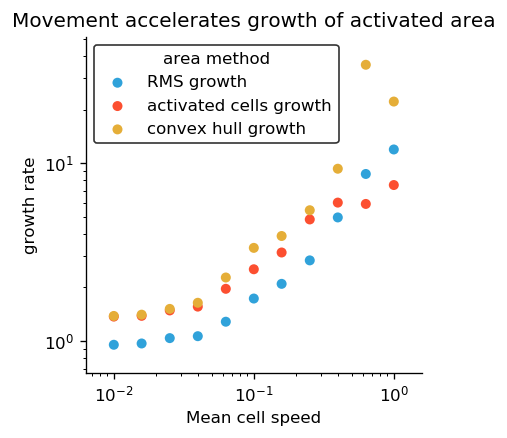

In [217]:
plt = hv.Scatter(
    data = data,
    kdims = ["Mean cell speed"],
    vdims = ["growth rate", "area method"],
).groupby(
    "area method"
).opts(
    logx=True,
    logy=True,
    title="Movement accelerates growth of activated area"
).overlay()

hv.output(plt, dpi=120)